# initial notebook for connectivity using gdal_proximity
- needs xarray-spatial, not avaliable in datacube
- can make venvs, but for below just cloned repo (https://github.com/makepath/xarray-spatial/tree/master)
- binary layers of wofs, items, mangrove, saltmarsh, saltflats, stream network

In [1]:
%matplotlib inline

import sys
from osgeo import gdal
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd

sys.path.insert(0, "/home/jovyan/code/dea-notebooks/Tools")
import datacube
from dea_tools.plotting import display_map
from datacube.utils.cog import write_cog
from datacube.utils.geometry import Geometry
from dea_tools.spatial import xr_rasterize
from datacube.testutils.io import rio_slurp_xarray
dc = datacube.Datacube()


sys.path.insert(1, "/home/jovyan/code/xarray-spatial")
from xrspatial.proximity import proximity

# load virtual product
import importlib
from datacube.virtual import catalog_from_file
from datacube.virtual import DEFAULT_RESOLVER
catalog = catalog_from_file('../virtual_products/virtual_product_cat_wcf.yaml')

In [2]:
# add time (not a range, just repeat year input here)
time_range = ("2020", "2020")

# export as geotiff?
export = True

In [3]:
# GA coastal tiles
vector_file = '../data/geojson/ga_summary_grid_c3_coastal.geojson'
attribute_col = 'geometry'

gdf = gpd.read_file(vector_file)
mainland_grid = gdf[gdf['type'] == 'mainland']

id_list = []
for index, row in mainland_grid.iterrows():
    id_list.append(row['id'])
mainland_grid.explore()

In [56]:
gdf = mainland_grid.loc[mainland_grid['id'] == 168]

In [57]:
gdf.explore()

In [33]:
# # Calculate buffer distance
# buffer_distance_x = (gdf.total_bounds[2] - gdf.total_bounds[0]) / 2
# buffer_distance_y = (gdf.total_bounds[3] - gdf.total_bounds[1]) / 2

# # Buffer geometries
# buffered_geometries = gdf['geometry'].buffer(distance=min(buffer_distance_x, buffer_distance_y))

# # Create new GeoDataFrame with buffered geometries
# # buffered_gdf = gdf.copy()
# # buffered_gdf['geometry'] = buffered_geometries
# gdf['buffered_geometry'] = buffered_geometries

In [34]:
# Create the 'query' dictionary object
res = (-30, 30)

query = {
    "time": time_range,
    'resolution':res}

query_buffered = {
    "time": time_range,
    'resolution':res}

In [35]:


# Function to buffer a geometry by a factor of two
def double_buffer(geometry):
    return geometry.buffer(distance=0.5)  # Buffer by 0.5 to double the size

# Apply the double_buffer function to the geometry column
gdf['doubled_geometry'] = gdf['geometry'].apply(double_buffer)

# # Create a new GeoDataFrame with the new geometries
# gdf_doubled = gpd.GeoDataFrame(gdf, geometry='doubled_geometry')

# # Print the new GeoDataFrame
# gdf_doubled.bounds


/env/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [36]:
gdf

,region_code,ix,iy,utc_offset,id,type,geometry,doubled_geometry
225,x21y20,21,20,8,226,mainland,"POLYGON ((124.85086 -31.55198, 124.79331 -32.4...","POLYGON ((124.87268 -31.05246, 125.89229 -31.0..."


In [37]:
# def double_buffer(geometry):
#     buffer_distance = 0.5  # Buffer by half the size
#     return geometry.buffer(distance=buffer_distance)

# # Apply the double_buffer function to the geometry column
# gdf['doubled_geometry'] = gdf['geometry'].apply(double_buffer)

# # Create a new GeoDataFrame with the new geometries
# gdf_doubled = gpd.GeoDataFrame(gdf, geometry='doubled_geometry')

In [38]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1 entries, 225 to 225
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   region_code       1 non-null      object  
 1   ix                1 non-null      int64   
 2   iy                1 non-null      int64   
 3   utc_offset        1 non-null      int64   
 4   id                1 non-null      int64   
 5   type              1 non-null      object  
 6   geometry          1 non-null      geometry
 7   doubled_geometry  1 non-null      geometry
dtypes: geometry(2), int64(4), object(2)
memory usage: 72.0+ bytes


In [39]:
# Loop through polygons in geodataframe and add geom to queries
for index, row in gdf.iterrows():
    print(f'Feature: {index + 1}/{len(gdf)}')
    
    # Extract the feature's geometry as a datacube geometry object
    geom = Geometry(geom=row.geometry, crs=gdf.crs)
    
    # Update the query to include our geopolygon
    query.update({'geopolygon': geom})

    # Extract the feature's geometry as a datacube geometry object
    geom = Geometry(geom=row.doubled_geometry, crs=gdf.crs)
    
    # Update the query to include our geopolygon
    query_buffered.update({'geopolygon': geom})
    
    
query_notime = {key: query[key] for key in query.keys()
       & {'resolution', 'geopolygon'}}
query_buffered_notime = {key: query_buffered[key] for key in query_buffered.keys()
       & {'resolution', 'geopolygon'}}
    
geometry = query_notime['geopolygon'].geom
bbox = geometry.bounds   

# this is how to load streams
geometry = query_buffered_notime['geopolygon'].geom
doubled_bbox = geometry.bounds

# # Extracting specific keys from dictionary (removing time to load things like item and srtm)
# query_notime = {key: query[key] for key in query.keys()
#        & {'resolution', 'geopolygon'}}
    

    
#     # Convert buffered_geometry to GeoSeries
#     buffered_geometry = gpd.GeoSeries([buffered_geometry], index=[index], crs=gdf.crs)

#     # Assign buffered geometries to the GeoDataFrame
#     gdf.at[index, 'buffered_geometry'] = buffered_geometry

#     # Extract the feature's geometry as a datacube geometry object
#     geom = Geometry(geom=row.geometry, crs=gdf.crs)
#     # Update the query to include our geopolygon
#     query.update({'geopolygon': geom})

#     # Extract the feature's buffered geometry as a datacube geometry object
#     buffered_geom = Geometry(geom=buffered_geometry.iloc[0], crs=gdf.crs)
    
#     # Extract the feature's geometry as a datacube geometry object
#     geom1 = Geometry(geom=row.geometry, crs=gdf.crs)
#     # Update the query to include our geopolygon
#     query.update({'geopolygon': geom1})

#     # Extract the feature's buffered geometry as a datacube geometry object
#     geom2 = Geometry(geom=buffered_geometry.iloc[0], crs=gdf.crs)
#     # Update the query to include our geopolygon
#     query_buffered.update({'geopolygon': geom2})
    
# # Extracting specific keys from dictionary (removing time to load things like item and srtm)
# query_notime = {key: query[key] for key in query.keys()
#        & {'resolution', 'geopolygon'}}
# query_buffered_notime = {key: query_buffered[key] for key in query_buffered.keys()
#        & {'resolution', 'geopolygon'}}

Feature: 226/1


In [40]:
query_notime

{'geopolygon': Geometry(POLYGON ((124.85085833810612 -31.551978617237246, 124.79330714517538 -32.40866970331247, 125.82109661613829 -32.45362851736881, 125.87046751477644 -31.596527210816568, 124.85085833810612 -31.551978617237246)), EPSG:4326),
 'resolution': (-30, 30)}

In [41]:
query_buffered_notime

{'geopolygon': Geometry(POLYGON ((124.87268343260132 -31.052455179098178, 125.89229260927164 -31.0970037726775, 125.94157857272666 -31.101609826360132, 125.99016755624427 -31.111066707714, 126.03758332521814 -31.125281727124243, 126.08336114405516 -31.144115559096, 126.12705233118281 -31.16738360782369, 126.1682286567062 -31.19485781646758, 126.2064865396126 -31.226268902404513, 126.24145100338495 -31.261308996544344, 126.27277935125466 -31.299634660843488, 126.3001645250712 -31.340870254439974, 126.32333811486735 -31.384611615417615, 126.34207298962257 -31.43043002211321, 126.3561855234394 -31.477876395140928, 126.36553739531377 -31.52648569894855, 126.37003694485894 -31.57578149976472, 126.36964007069531 -31.62528063526338, 126.32026917205717 -32.482381941815625, 126.31511399998664 -32.530744173727506, 126.30528447243289 -32.578376743075005, 126.29087359564937 -32.624828954054735, 126.2720177242728 -32.669661279325744, 126.24889527114584 -32.71244951878434, 126.22172501918803 -32.752

In [42]:
bbox

(124.79330714517538,
 -32.45362851736881,
 125.87046751477644,
 -31.551978617237246)

In [43]:
doubled_bbox

(124.29357211516258,
 -32.95315083560398,
 126.37003694485894,
 -31.052455179098178)

In [44]:
# geometry = query_notime['geopolygon'].geom
# bbox = geometry.bounds


In [45]:
# # this is how to load streams
# geometry = query_buffered_notime['geopolygon'].geom
# doubled_bbox = geometry.bounds


In [46]:
# # Loop through polygons in geodataframe and add geom to queries
# for index, row in gdf.iterrows():
#     print(f'Feature: {index + 1}/{len(gdf)}')
    
#     # Calculate buffer distance
#     buffer_distance_x = (row['geometry'].bounds[2] - row['geometry'].bounds[0]) / 2
#     buffer_distance_y = (row['geometry'].bounds[3] - row['geometry'].bounds[1]) / 2

#     # Buffer geometries
#     buffered_geometry = row['geometry'].buffer(distance=min(buffer_distance_x, buffer_distance_y))

#     # Create new GeoDataFrame with buffered geometries
#     # buffered_gdf = row.copy()
#     # buffered_gdf['geometry'] = buffered_geometries
#     # gdf['buffered_geometry'] = buffered_geometries

    
#     # Convert buffered_geometry to GeoSeries
#     buffered_geometry = gpd.GeoSeries([buffered_geometry], index=[index], crs=gdf.crs)

#     # Assign buffered geometries to the GeoDataFrame
#     gdf.at[index, 'buffered_geometry'] = buffered_geometry

#     # Extract the feature's geometry as a datacube geometry object
#     geom = Geometry(geom=row.geometry, crs=gdf.crs)
#     # Update the query to include our geopolygon
#     query.update({'geopolygon': geom})

#     # Extract the feature's buffered geometry as a datacube geometry object
#     buffered_geom = Geometry(geom=buffered_geometry.iloc[0], crs=gdf.crs)
    
#     # Extract the feature's geometry as a datacube geometry object
#     geom1 = Geometry(geom=row.geometry, crs=gdf.crs)
#     # Update the query to include our geopolygon
#     query.update({'geopolygon': geom1})

#     # Extract the feature's buffered geometry as a datacube geometry object
#     geom2 = Geometry(geom=buffered_geometry.iloc[0], crs=gdf.crs)
#     # Update the query to include our geopolygon
#     query_buffered.update({'geopolygon': geom2})
    
# # Extracting specific keys from dictionary (removing time to load things like item and srtm)
# query_notime = {key: query[key] for key in query.keys()
#        & {'resolution', 'geopolygon'}}
# query_buffered_notime = {key: query_buffered[key] for key in query_buffered.keys()
#        & {'resolution', 'geopolygon'}}

In [47]:
%%time
# Load STRM
srtm_ds = dc.load(product = 'ga_srtm_dem1sv1_0', output_crs="EPSG:3577", **query_buffered_notime)
srtm = srtm_ds.dem_h
# for connectivity model less than 10m AHD == True (this needs to be thresholded as minimum at 0 for STF extent product due to supratidal areas not being below 0 AHD
AHD_min = -6
AHD_max = 10
# SRTM
lessthan10m_AHD = srtm <= AHD_max
greaterthan0m_AHD = srtm >= AHD_min
# srtm_mask = lessthan10m_AHD
srtm_mask = lessthan10m_AHD & greaterthan0m_AHD

# Load SRTM tile bounds for masking at the end
srtm_ds_tile = dc.load(product = 'ga_srtm_dem1sv1_0', output_crs="EPSG:3577", **query_notime)
srtm_tile = srtm_ds_tile.dem_h
tile = xr.DataArray(np.ones_like(srtm_tile), coords=srtm_tile.coords, dims=srtm_tile.dims, attrs=srtm_tile.attrs)

# Load in water from wofs
wofs = dc.load(product="ga_ls_wo_fq_cyear_3", output_crs="EPSG:3577", measurements=["frequency"], **query_buffered)
# get water class
water = xr.where((wofs.frequency >= 0.2), 1, 0).astype('int8')

# Load ITEMs
item_ds = dc.load(product = 'item_v2', output_crs="EPSG:3577", **query_buffered_notime)
item = item_ds.relative
intertidal = (item >= 2) & (item <= 8)


# Load in mangroves
DEAmangrove = dc.load(product = 'ga_ls_mangrove_cover_cyear_3', output_crs="EPSG:3577", **query_buffered)

# if no mangroves within AOI, create dummy xr.dataarray
if DEAmangrove.data_vars == {}:
    mangrove = xr.DataArray(np.zeros_like(srtm), coords=srtm.coords, dims=srtm.dims, attrs=srtm.attrs)
else:
    # get output of mangrove == 1, not mangrove == 0
    mangrove = (DEAmangrove.canopy_cover_class != 255)
    

# Load in saltmarsh
geotiff_path = '/home/jovyan/gdata1/data/saltmarsh/JCU_Australia-saltmarsh-extent_v1-0.tif'
# load in geotiff again but with identical extent from srtm
saltmarsh = rio_slurp_xarray(geotiff_path, gbox=srtm.geobox)
saltmarsh.attrs['crs'] = 'EPSG:3577'


# Load in saltflat
geotiff_path = '/home/jovyan/gdata1/data/saltmarsh/JCU_Australia-saltflat-extent_v1-0.tif'
# load in geotiff again but with identical extent from srtm
saltflat = rio_slurp_xarray(geotiff_path, gbox=srtm.geobox)
saltflat.attrs['crs'] = 'EPSG:3577'


# Load in Geofabric mapped stream
streams_gdf = gpd.read_file('/home/jovyan/gdata1/projects/coastal/supratidal_forests/data/Geofabric/AHGFMappedStream.shp', bbox=doubled_bbox)
streams_mask = xr_rasterize(streams_gdf, srtm_ds)

CPU times: user 21.7 s, sys: 3.5 s, total: 25.2 s
Wall time: 1min 47s


In [48]:
# remove time dim on some vars
water = water.squeeze('time')
intertidal = intertidal.squeeze('time')
mangrove = mangrove.squeeze('time')
srtm_mask = srtm_mask.squeeze('time').astype('int8')

In [49]:
# combine masks
aquatic = xr.where((water == True) | (intertidal == True) | 
                   (mangrove == True) | (saltmarsh == True) | 
                   (saltflat == True) | (streams_mask == True), 1, 0).astype('int8')

In [50]:
# xrspatial proximity - https://xarray-spatial.org/reference/_autosummary/xrspatial.proximity.proximity.html
# seems it is in same units as crs (EPSG3577 = metres)
proximity_agg = proximity(aquatic)

# mask with srtm_mask (need to do before normalisation so that min and max are within bounds of 0-10m elevation)
proximity_agg_mask = proximity_agg.where(srtm_mask)

In [51]:
# Find the minimum and maximum values in the data array - taking a percentile just to ensure any extreme odd values are not considered
min_value = np.nanpercentile(proximity_agg_mask, 0.01)
max_value = np.nanpercentile(proximity_agg_mask, 99.99)
print(f"Minimum Value: {min_value}")
print(f"Maximum Value: {max_value}")

# Clip values above max_value percentile
# proximity_agg_mask = xr.where(np.isnan(proximity_agg_mask), proximity_agg_mask, np.minimum(proximity_agg_mask, max_value))
proximity_agg_mask = xr.where(proximity_agg_mask >= max_value, max_value, proximity_agg_mask.values)

# Normalize the data to the range [0, 1] by subtracting the minimum and dividing by the range
proximity_norm = (proximity_agg_mask - min_value) / (max_value - min_value)

# invert the normalisation to make connectivity layer output
connectivity = (1 - proximity_norm)

# removing water, mangroves and items from connectivity output #
# not water == True
not_water = (1 - water)
not_water = not_water == 1

# not exposed intertidal == True
not_intertidal = (1 - intertidal)

# not mangrove == True
not_mangrove = (1 - mangrove)
not_mangrove = not_mangrove == 1

# combine masks
# where its not mangrove or exposed intertidal
combine_not_masks = xr.where((not_water == True) & (not_intertidal == True) & (not_mangrove == True) , 1, np.nan)

# remove areas that would not be supratidal forest connectivity (i.e. water bodies and mangroves to np.nan)
connectivity_mask = connectivity * combine_not_masks


Minimum Value: 0.0
Maximum Value: 13139.14022656246


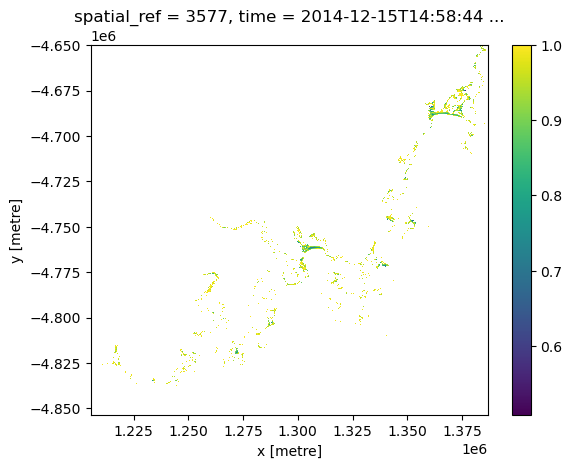

In [25]:
connectivity_mask.plot()

In [26]:
connectivity_tile = connectivity_mask * tile

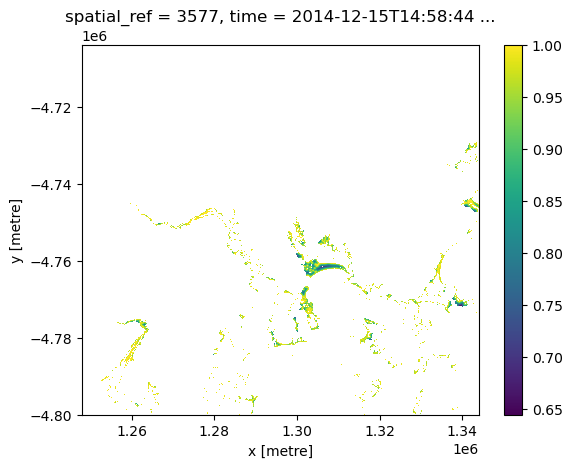

In [27]:
connectivity_tile.plot()

In [28]:
# export
if export == False:
        pass
else:
    write_cog(geo_im=connectivity_mask,
      fname=vector_file.rsplit('/', 1)[-1].split('.')[0] + '_gridID_' + str(row['id']) +'_connectivity_mask_' + time_range[0] + '.tif', # first part gets AOI name
      overwrite=True,
      nodata=0.0)
    write_cog(geo_im=connectivity_tile,
      fname=vector_file.rsplit('/', 1)[-1].split('.')[0] + '_gridID_' + str(row['id']) +'_connectivity_tile_' + time_range[0] + '.tif', # first part gets AOI name
      overwrite=True,
      nodata=0.0)

In [29]:
#### NOTE: ISSUE IS NOW ABOUT NORMALISING OVER DISTANCES 
# which wasn't really an issue in the previous approach (it was more about aquatic layer)
